<p>Prepare subconjuntos de entrenamiento, validaci´on y pruebas id´enticos a los que utiliz´o en el ´ultimo
´ıtem de la tarea 1. Normalice las im´agenes de entrenamiento y pruebas, dividiendo las intensidades
originales de pixel en cada canal por 255. Es importante recordar que en la tarea1 representamos las
im´agenes como un vector unidimensional. Por lo tanto, antes de trabajar con CNNs ser´a necesario
recuperar la forma original de las im´agenes. Adem´as, si desea trabajar con el orden de las dimensiones
denominado ’tf’ (por defecto para TensorFlow†) deber´a hacer realizar la transposici´on correspondiente.
Finalmente, genere una representaci´on adecuada de las salidas deseadas de la red.</p>

In [1]:
import keras
import pickle
import numpy as np
import os
from scipy.misc import imread
import sys
from keras import backend as K
K.set_image_dim_ordering('th')

sys.getdefaultencoding()

def unpickle(file):
    import cPickle
    fo = open(file, rb)
    dict = cPickle.load(fo)
    fo.close()
    return dict

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
    return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

x_train, y_train, x_test, y_test = load_CIFAR10("datasets/")
num_classes = len(np.unique(y_train))
x_train = x_train.reshape((x_train.shape[0],3,32,32))

x_test= x_test.reshape((x_test.shape[0],3,32,32))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


Using TensorFlow backend.


<p>B) Defina una CNN con arquitectura C × P × C × P × F × F. Para ambas capas convolucionales utilice
64 filtros de 3 × 3 y funciones de activaci´on ReLu. Para las capas de pooling utilice filtros de 2 × 2 con
stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo m´as compacto posible
que muestre los cambios de forma (dimensionalidad) que experimenta un patr´on de entrada a medida
que se ejecuta un forward-pass y el n´umero de par´ametros de cada capa.
</p>

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
print(x_train.shape)
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(3,32,32)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


(50000, 3, 32, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 64, 16, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 8, 8)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0 

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", input_shape=(3, 32, 32...)`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`


<p>C) Entrene la CNN definida en (b) utilizando SGD. En este dataset, una tasa de aprendizaje \segura"
es  = 10􀀀4 o inferior, pero durante las primeras \epochs" el entrenamiento resulta demasiado lento.
Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento.
Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje  = 10􀀀3 y dividir por 2
ese valor cada 10 epochs. Suponga ademas que no queremos usar una tasa de aprendizaje menor a
 = 10􀀀5. Dena esta regla de ajuste para  y entrene la CNN denida en (a) durante 25 epochs.
Construya un graco que muestre los errores de entrenamiento, validacion y pruebas como funcion del
numero de \epochs".</p>

In [4]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=400, nb_epoch=25,
    validation_data=(x_test, y_test),shuffle=True,callbacks=[lrate])


<function step_decay at 0x00000138A0AC1620>


D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 38s - loss: 2.2701 - acc: 0.1605 - val_loss: 2.2264 - val_acc: 0.2220
Epoch 2/25
50000/50000 [==============================] - 38s - loss: 2.1489 - acc: 0.2550 - val_loss: 2.0517 - val_acc: 0.2754
Epoch 3/25
50000/50000 [==============================] - 37s - loss: 1.9965 - acc: 0.2951 - val_loss: 1.9492 - val_acc: 0.3179
Epoch 4/25
50000/50000 [==============================] - 37s - loss: 1.9285 - acc: 0.3207 - val_loss: 1.8991 - val_acc: 0.3318
Epoch 5/25
50000/50000 [==============================] - 38s - loss: 1.8870 - acc: 0.3428 - val_loss: 1.8685 - val_acc: 0.3502
Epoch 6/25
50000/50000 [==============================] - 38s - loss: 1.8593 - acc: 0.3528 - val_loss: 1.8402 - val_acc: 0.3654
Epoch 7/25
50000/50000 [==============================] - 38s - loss: 1.8324 - acc: 0.3653 - val_loss: 1.8135 - val_acc: 0.3729
Epoch 8/25
50000/50000 [==============================

In [3]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append([logs.get('acc'), logs.get('acc')])
        
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

lrate = LearningRateScheduler(step_decay)
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=400, nb_epoch=25, validation_data=(x_test, y_test),shuffle=True,callbacks=[lrate])

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 41s - loss: 2.2825 - acc: 0.1425 - val_loss: 2.2515 - val_acc: 0.1995
Epoch 2/25
50000/50000 [==============================] - 37s - loss: 2.2002 - acc: 0.2180 - val_loss: 2.1387 - val_acc: 0.2425
Epoch 3/25
50000/50000 [==============================] - 37s - loss: 2.0766 - acc: 0.2703 - val_loss: 2.0125 - val_acc: 0.3110
Epoch 4/25
50000/50000 [==============================] - 37s - loss: 1.9653 - acc: 0.3119 - val_loss: 1.9202 - val_acc: 0.3258
Epoch 5/25
50000/50000 [==============================] - 37s - loss: 1.9041 - acc: 0.3357 - val_loss: 1.8843 - val_acc: 0.3394
Epoch 6/25
50000/50000 [==============================] - 37s - loss: 1.8753 - acc: 0.3481 - val_loss: 1.8626 - val_acc: 0.3509
Epoch 7/25
50000/50000 [==============================] - 37s - loss: 1.8481 - acc: 0.3596 - val_loss: 1.8318 - val_acc: 0.3633
Epoch 8/25
50000/50000 [==============================

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


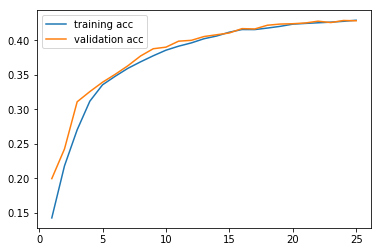

In [14]:
import matplotlib.pyplot as plt
epochs = list(range(1,26))
print(epochs)
train_accuracy = history_callback.history["acc"]
validation_accyracy = history_callback.history["val_acc"]
plt.plot(epochs, train_accuracy )
plt.plot( epochs, validation_accyracy )
plt.legend( ["training acc", "validation acc"])
plt.show()

<p>D) Entrene la CNN denida en (b) utilizando RMSProp durante 25 epochs. Elija la funcion de perdida
mas apropiada para este problema. Construya nalmente un graco que muestre los errores de entrenamiento,
validacion y pruebas como funcion del numero de \epochs".</p>

In [7]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=150,nb_epoch=25,
validation_data=(x_test, y_test),shuffle=True)



D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 37s - loss: 1.6327 - acc: 0.4233 - val_loss: 1.3168 - val_acc: 0.5222
Epoch 2/25
50000/50000 [==============================] - 34s - loss: 1.1432 - acc: 0.5989 - val_loss: 1.0470 - val_acc: 0.6226
Epoch 3/25
50000/50000 [==============================] - 34s - loss: 0.9487 - acc: 0.6705 - val_loss: 0.9385 - val_acc: 0.6732
Epoch 4/25
50000/50000 [==============================] - 34s - loss: 0.8138 - acc: 0.7190 - val_loss: 1.0125 - val_acc: 0.6444
Epoch 5/25
50000/50000 [==============================] - 34s - loss: 0.6875 - acc: 0.7604 - val_loss: 0.9563 - val_acc: 0.6812
Epoch 6/25
50000/50000 [==============================] - 36s - loss: 0.5697 - acc: 0.8024 - val_loss: 0.9496 - val_acc: 0.6916
Epoch 7/25
50000/50000 [==============================] - 34s - loss: 0.4570 - acc: 0.8428 - val_loss: 0.9229 - val_acc: 0.7054
Epoch 8/25
50000/50000 [==============================

import matplotlib.pyplot as plt
epochs = list(range(1,26))
print(epochs)
train_accuracy = history_callback.history["acc"]
validation_accyracy = history_callback.history["val_acc"]
plt.plot(epochs, train_accuracy )
plt.plot( epochs, validation_accyracy )
plt.legend( ["training acc", "validation acc"])
plt.show()

<p>Se aprecia que el gráfico obtenido entrega errores de validación muy altos, mientras que el error de entrenamiento es casi cero<p>

<p>E) Se ha sugerido que la practica bastante habitual de continuar una capa convolucional con una capa de
pooling puede generar una reduccion prematura de las dimensiones del patron de entrada. Experimente
con una arquitectura del tipo C C P C C P F F. Use 64 ltros para las primeras 2 capas
convolucionales y 128 para las ultimas dos. Reflexione sobre que le parece mas sensato: >mantener el
tama~no de los ltros usados anteriormente? o >usar ltros mas grandes en la segunda capa convolucional
y mas peque~nos en la primera? o >usar ltros mas peque~nos en la segunda capa convolucional y mas
grandes en la primera? Hint: con esta nueva arquitectura debiese superar el 70% de accuracy (de
validacion/test) antes de 5 epochs, pero la arquitectura es mas sensible a overtting por lo que podra
ser conveniente agregar un regularizador. Como resultado nal de esta actividad gracque los errores
de entrenamiento, validacion y pruebas como funcion del numero de \epochs" (jando el maximo en
un numero razonable como T = 25).</p>

In [4]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(3,32,32)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 16, 16)       73856     
__________

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", input_shape=(3, 32, 32...)`
  from ipykernel import kernelapp as app
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding=

In [5]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=150,nb_epoch=25,
validation_data=(x_test, y_test),shuffle=True)

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 78s - loss: 1.7208 - acc: 0.3797 - val_loss: 1.4518 - val_acc: 0.4950
Epoch 2/25
50000/50000 [==============================] - 75s - loss: 1.1569 - acc: 0.5904 - val_loss: 1.0835 - val_acc: 0.6171
Epoch 3/25
50000/50000 [==============================] - 75s - loss: 0.8905 - acc: 0.6881 - val_loss: 0.9400 - val_acc: 0.6744
Epoch 4/25
50000/50000 [==============================] - 78s - loss: 0.7242 - acc: 0.7468 - val_loss: 0.8419 - val_acc: 0.7193
Epoch 5/25
50000/50000 [==============================] - 78s - loss: 0.5976 - acc: 0.7916 - val_loss: 0.8540 - val_acc: 0.7205
Epoch 6/25
50000/50000 [==============================] - 78s - loss: 0.4886 - acc: 0.8307 - val_loss: 0.8197 - val_acc: 0.7436
Epoch 7/25
50000/50000 [==============================] - 75s - loss: 0.3863 - acc: 0.8652 - val_loss: 1.3841 - val_acc: 0.6633
Epoch 8/25
50000/50000 [==============================

In [4]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(3,32,32)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=150,nb_epoch=8,
validation_data=(x_test, y_test),shuffle=True)

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", input_shape=(3, 32, 32...)`
  from ipykernel import kernelapp as app
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding=

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_11 (Activation)   (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
activation_12 (Activation)   (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 16, 16)       73856     
__________

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 79s - loss: 1.7475 - acc: 0.3734 - val_loss: 1.2778 - val_acc: 0.5405
Epoch 2/8
50000/50000 [==============================] - 75s - loss: 1.1539 - acc: 0.5938 - val_loss: 1.0769 - val_acc: 0.6114
Epoch 3/8
50000/50000 [==============================] - 78s - loss: 0.8923 - acc: 0.6894 - val_loss: 0.8839 - val_acc: 0.6951
Epoch 4/8
50000/50000 [==============================] - 75s - loss: 0.7204 - acc: 0.7486 - val_loss: 1.0588 - val_acc: 0.6525
Epoch 5/8
50000/50000 [==============================] - 81s - loss: 0.5887 - acc: 0.7963 - val_loss: 0.7971 - val_acc: 0.7378
Epoch 6/8
50000/50000 [==============================] - 77s - loss: 0.4803 - acc: 0.8317 - val_loss: 0.7975 - val_acc: 0.7274
Epoch 7/8
50000/50000 [==============================] - 75s - loss: 0.3888 - acc: 0.8627 - val_loss: 0.9349 - val_acc: 0.7428
Epoch 8/8
50000/50000 [==============================] - 80s 

In [3]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(3,32,32)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 20, 20, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Convolution2D(128, 20, 20, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=150,nb_epoch=8,
validation_data=(x_test, y_test),shuffle=True)

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", input_shape=(3, 32, 32...)`
  from ipykernel import kernelapp as app
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (20, 20), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (20, 20), padd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 16, 16)       3276928   
__________

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '



Total params: 10,923,594
Trainable params: 10,923,594
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 217s - loss: 2.1183 - acc: 0.2838 - val_loss: 2.1769 - val_acc: 0.3152
Epoch 2/8
50000/50000 [==============================] - 225s - loss: 1.2290 - acc: 0.5665 - val_loss: 1.0832 - val_acc: 0.6286
Epoch 3/8
50000/50000 [==============================] - 204s - loss: 0.9111 - acc: 0.6817 - val_loss: 1.1176 - val_acc: 0.6012
Epoch 4/8
50000/50000 [==============================] - 220s - loss: 0.7114 - acc: 0.7539 - val_loss: 1.1437 - val_acc: 0.6899
Epoch 5/8
50000/50000 [==============================] - 226s - loss: 0.5698 - acc: 0.8053 - val_loss: 0.8045 - val_acc: 0.7419
Epoch 6/8
50000/50000 [==============================] - 215s - loss: 0.4345 - acc: 0.8507 - val_loss: 0.9317 - val_acc: 0.7281
Epoch 7/8
50000/50000 [==============

In [3]:
model = Sequential()
model.add(Convolution2D(64, 20, 20, border_mode='same', input_shape=(3,32,32)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 20, 20, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=150,nb_epoch=8,
validation_data=(x_test, y_test),shuffle=True)

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (20, 20), padding="same", input_shape=(3, 32, 32...)`
  from ipykernel import kernelapp as app
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (20, 20), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 32, 32)        76864     
_________________________________________________________________
activation_5 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 32, 32)        1638464   
_________________________________________________________________
activation_6 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 16, 16)       73856     
__________

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 133s - loss: 14.4724 - acc: 0.0998 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/8
50000/50000 [==============================] - 123s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/8
50000/50000 [==============================] - 122s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/8
50000/50000 [==============================] - 120s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/8
50000/50000 [==============================] - 120s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/8
50000/50000 [==============================] - 120s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/8
50000/50000 [==============================] - 120s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/8
50000/50000 [=================

<p> Se aprecia al agregar filtros más pequeños en las primeras capas un accuracy un poco mayor que con las capas dadas por la pregunta, y además de esto, el tiempo de entrenamiento aumenta considerablemente, por lo que en este problema especifico no es conveniente tener mayor número de filtros en el segundo par de capas convolucionales.</p>

<p>En el caso de aumentar el tamaño del filtro de las primeras capas, se obtienen resultados extraños</p>

<p>F) Algunos investigadores, han propuesto que las capas de pooling se pueden reemplazar por capas
convoluciones con stride 2. >Se reduce dimensionalidad de este modo? Compruebelo vericando los
cambios de forma (dimensionalidad) que experimenta un patron de entrada a medida que se ejecuta
un forward-pass. Entrene la red resultante con el metodo que preera, gracando los errores de entrenamiento,
validacion y pruebas como funcion del numero de \epochs" (jando el maximo en un numero
razonable como T = 25).</p>

In [4]:


model = Sequential()
model.add(Convolution2D(64, 20, 20, border_mode='same', input_shape=(3,32,32)))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history_callback = model.fit(x_train, y_train,batch_size=150,nb_epoch=5,
validation_data=(x_test, y_test),shuffle=True)

D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (20, 20), input_shape=(3, 32, 32..., padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", strides=(2, 2))`
D:\Users\Felipe\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 32, 32)        76864     
_________________________________________________________________
activation_9 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 32, 32)       73856     
_________________________________________________________________
activation_10 (Activation)   (None, 128, 32, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 15, 15)        73792     
_________________________________________________________________
flatten_3 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               7373312   
__________

<p>G) Una forma interesante de regularizar modelos entrenados para vision articial consiste en \aumentar"
el numero de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones,
corrimientos y re
exiones, tanto horizontales como verticales. Explique porque este procedimiento
podra ayudar a mejorar el modelo. Evalue experimentalmente la conveniencia de incorporarlo.</p>

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train,batch_size=150),
                    steps_per_epoch=x_train.shape[0]// 150,
                    epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
333/333 [==============================] - 36s - loss: 1.6919 - acc: 0.3995 - val_loss: 1.2463 - val_acc: 0.5543
Epoch 2/5
333/333 [==============================] - 33s - loss: 1.2547 - acc: 0.5572 - val_loss: 1.0687 - val_acc: 0.6226
Epoch 3/5
333/333 [==============================] - 36s - loss: 1.0826 - acc: 0.6210 - val_loss: 0.9366 - val_acc: 0.6754
Epoch 4/5
333/333 [==============================] - 33s - loss: 0.9899 - acc: 0.6555 - val_loss: 0.9003 - val_acc: 0.6857
Epoch 5/5
333/333 [==============================] - 33s - loss: 0.9167 - acc: 0.6788 - val_loss: 0.8292 - val_acc: 0.7142
